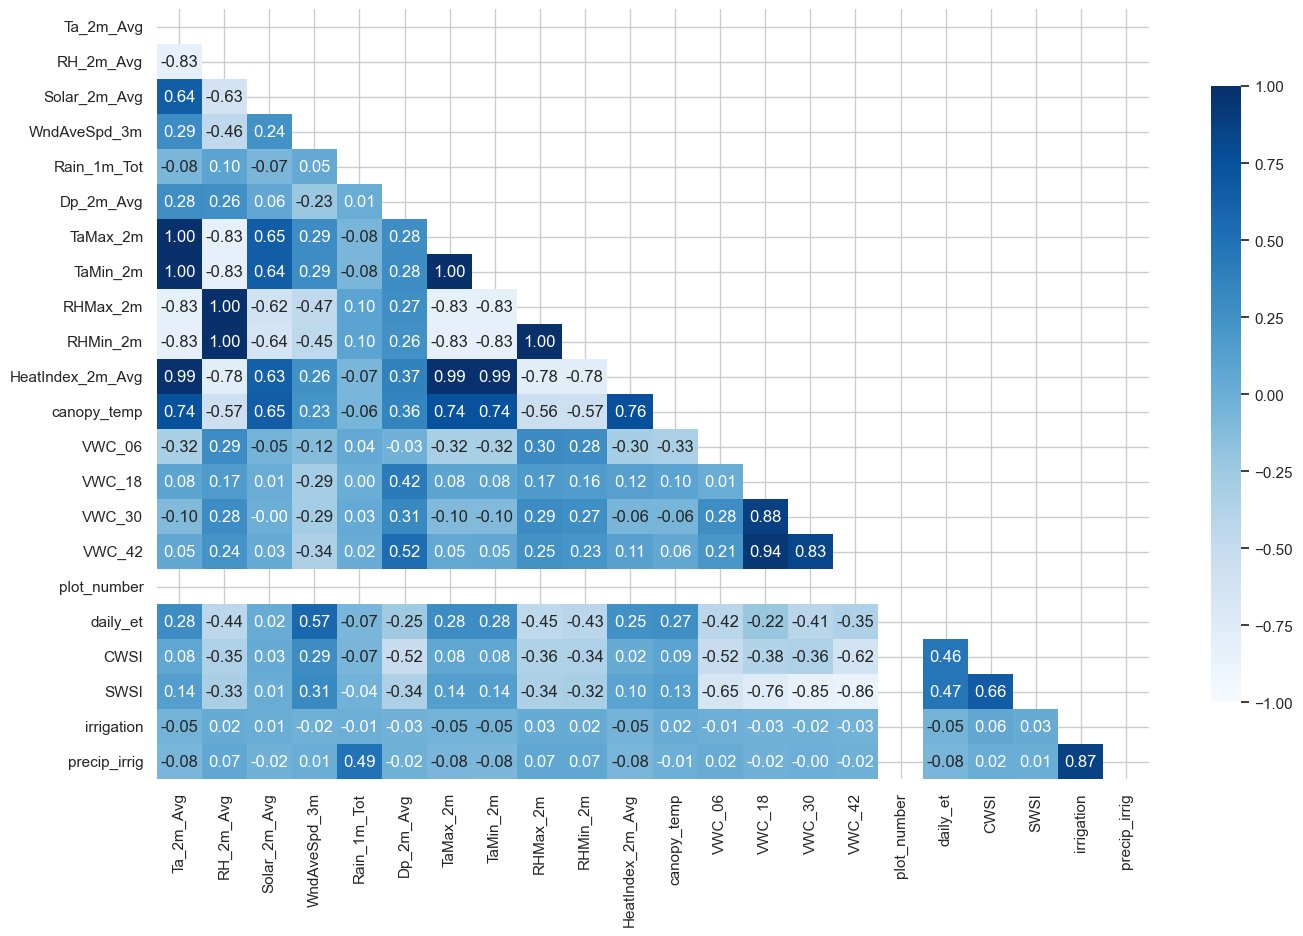

In [1]:
# Imports for data handling, processing, and visualization
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to the database and load data
conn = sqlite3.connect('processed_data.db')
query = 'SELECT * from data_table'
df = pd.read_sql_query(query, conn)
conn.close()

# Select plot_number 2014
df = df[df['plot_number'] == 2014]

# Select data between July 19 and September 06
df = df[(df['TIMESTAMP'] >= '2023-07-19') & (df['TIMESTAMP'] <= '2023-09-06')]

# Timestamp cyclical encoding
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)

time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

# Normalization (if beneficial after exploration)
scaler = MinMaxScaler()
target_columns = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']  # Adjust column names if necessary
df[target_columns] = scaler.fit_transform(df[target_columns])

# Set timestamp as index
df = df.set_index('TIMESTAMP')
df.sort_index(inplace=True)

# Drop rows with missing values
df = df.dropna()

# Visualization setup
sns.set(style='whitegrid', palette='muted', font_scale=1)
plt.figure(figsize=(16, 10))

# Select columns for correlation matrix
corr_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 
    'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 'canopy_temp', 'VWC_06', 'VWC_18', 
    'VWC_30', 'VWC_42', 'plot_number', 'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
]

exog_columns = time_columns + corr_columns

# Ensure the DataFrame contains only the columns of interest for the correlation matrix
df_corr = df[corr_columns].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Plot heatmap
sns.heatmap(df_corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
            vmin=-1, vmax=1, cbar_kws={"shrink": .8})

# Show plot
plt.show()


In [8]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def plot_forecast(actual, predicted, title='Forecast vs Actuals', xlabel='Time', ylabel='Value'):
    """
    Plot the actual vs predicted values for a time series.

    Parameters:
    - actual: Series, the actual values of the time series.
    - predicted: Series, the predicted values of the time series.
    - title: String, the title of the plot.
    - xlabel: String, the label for the x-axis.
    - ylabel: String, the label for the y-axis.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(predicted.index, predicted, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def undifference_data(predictions, last_observation):
    """
    Undifferences the model's predictions to convert them back to the original scale.

    Parameters:
    - predictions: Series or array containing the differenced predictions.
    - last_observation: The last actual observation in the original scale before the predictions start.

    Returns:
    - Series with undifferenced predictions.
    """
    undifferenced = [last_observation]
    for pred in predictions:
        last_observation = last_observation + pred
        undifferenced.append(last_observation)

    # The first value is the initial last observation, so the predictions start from the second element
    return pd.Series(undifferenced[1:])


def difference_data(df, target_columns, exog_columns=None):
    """
    Differences specified target and exogenous variables in the DataFrame and returns the last observation
    before differencing.

    Parameters:
    - df: DataFrame containing the time series data.
    - target_columns: List of column names for target variables to be differenced.
    - exog_columns: Optional list of column names for exogenous variables to be differenced.

    Returns:
    - Tuple of (DataFrame with differenced columns, dict of last observations for target and exogenous variables).
    """
    # Create a copy of the original dataframe
    df_differenced = df.copy()
    
    # Difference target variables
    df_differenced[target_columns] = df_differenced[target_columns].diff().dropna()

    # If exogenous variables are provided, difference and update last observations
    if exog_columns is not None:
        df_differenced[exog_columns] = df_differenced[exog_columns].diff().dropna()

    # Drop rows with missing values resulting from differencing
    df_differenced = df_differenced.dropna()

    return df_differenced


def run_adf_test(df, columns):
    """
    Runs the Augmented Dickey-Fuller test on specified columns of a DataFrame.

    Parameters:
    - df: DataFrame containing the time series data.
    - columns: List of column names to test for stationarity.

    Prints the ADF statistic, p-value, and critical values for each column.
    """
    for column in columns:
        result = adfuller(df[column].dropna())  # Ensure NA values are dropped
        print(f'ADF Statistic for {column}: {result[0]}')
        print(f'p-value: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value}')
            
        # Conclude based on the p-value
        if result[1] > 0.05:
            print(f"The p-value of {result[1]} is greater than 0.05, indicating the time series for {column} is not stationary.")
        else:
            print(f"The p-value of {result[1]} is less than 0.05, indicating the time series for {column} is stationary.")

# Example usage:
df_differenced = df.copy()

#order the dataframe by timestamp, drop nans and set frequency
df_differenced.sort_index(inplace=True)
df_differenced.dropna(inplace=True)

last_observation = df_differenced[target_columns].iloc[-1]

print(df_differenced[target_columns].tail(5))
print('Before differencing:')
run_adf_test(df_differenced, target_columns)
df_differenced = difference_data(df_differenced, target_columns, exog_columns)
print('After differencing:')
run_adf_test(df_differenced, target_columns)

#undifference the data and print it
undifferenced = undifference_data(df_differenced[target_columns[0]], last_observation[target_columns[0]])
print('Undifferenced data:')
print(undifferenced)

print('After undifferenced:')
print(df_differenced[target_columns].tail(5))

plot_forecast(df_differenced[target_columns[0]], undifferenced)

                       VWC_06    VWC_18    VWC_30    VWC_42
TIMESTAMP                                                  
2023-09-03 19:00:00  0.079454  0.070732  0.004878  0.002635
2023-09-03 20:00:00  0.072005  0.085366  0.004878  0.000000
2023-09-03 21:00:00  0.070764  0.090244  0.004878  0.002635
2023-09-03 22:00:00  0.067039  0.080488  0.004878  0.000000
2023-09-03 23:00:00  0.053383  0.082927  0.024390  0.000000
Before differencing:
ADF Statistic for VWC_06: -1.2475623503218272
p-value: 0.6528085043734619
Critical Values:
	1%: -3.4380849118778234
	5%: -2.86495432618506
	10%: -2.5685880571933963
The p-value of 0.6528085043734619 is greater than 0.05, indicating the time series for VWC_06 is not stationary.
ADF Statistic for VWC_18: -5.142907494257617
p-value: 1.148557329312075e-05
Critical Values:
	1%: -3.438262743153934
	5%: -2.8650327208928976
	10%: -2.5686298171529347
The p-value of 1.148557329312075e-05 is less than 0.05, indicating the time series for VWC_18 is stationary.
ADF 

Forecasting for VWC_06


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pr

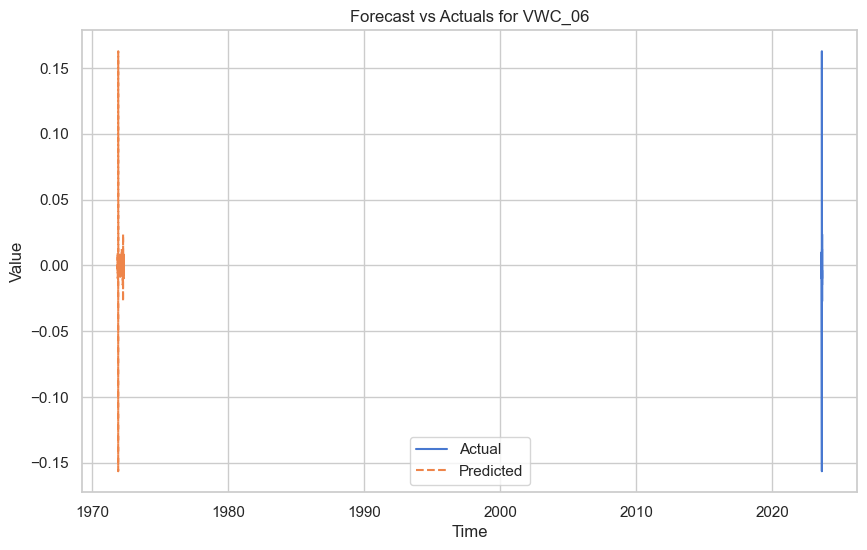

RMSE for VWC_06 on test data: 6.288839195331323e-16
Forecasting for VWC_18


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pr

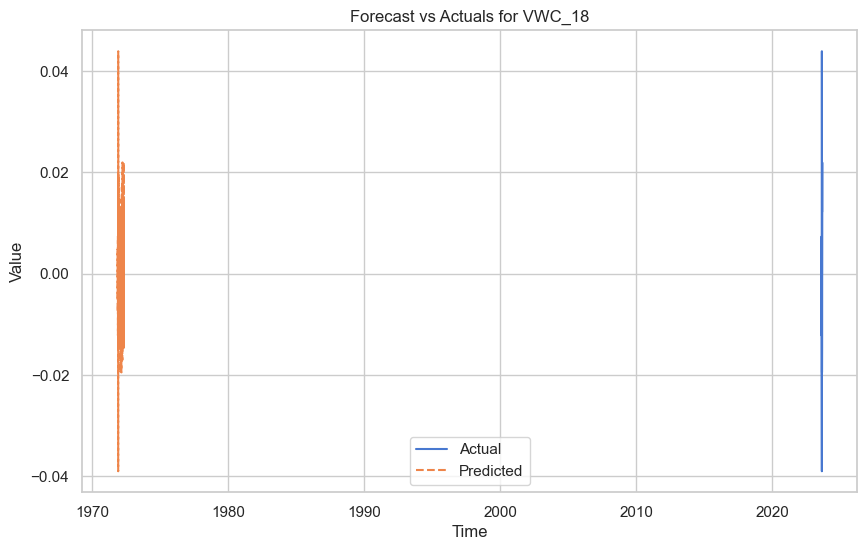

RMSE for VWC_18 on test data: 3.059206284504034e-16
Forecasting for VWC_30


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pr

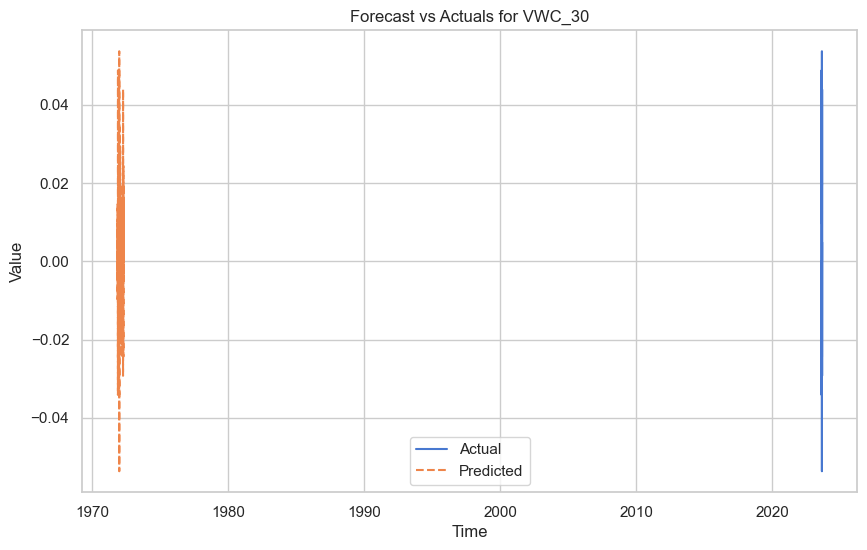

RMSE for VWC_30 on test data: 1.5884568696193464e-16
Forecasting for VWC_42


c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\bnsoh2\Desktop\venvs\ml_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pr

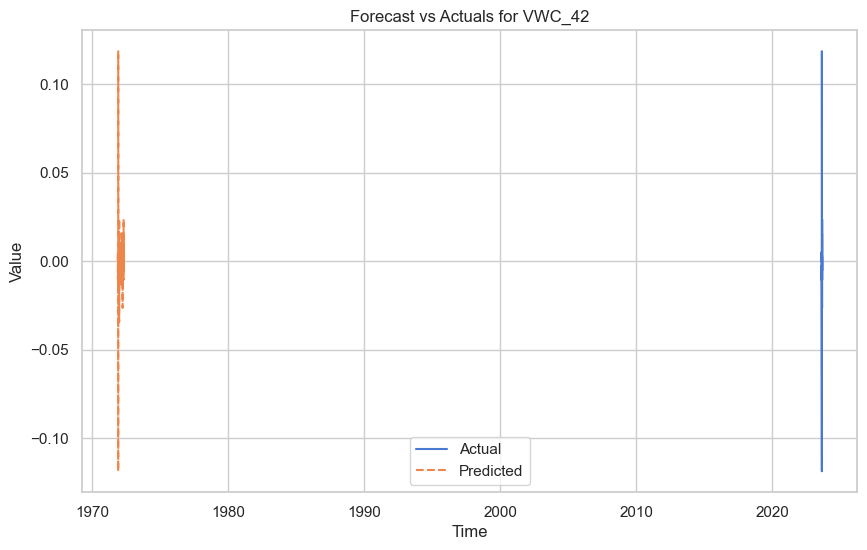

RMSE for VWC_42 on test data: 6.525020571335633e-17


In [13]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error

#order the dataframe by timestamp, drop nans and set frequency
df_differenced.sort_index(inplace=True)
df_differenced.dropna(inplace=True)

print(f"Inferred frequency: {pd.infer_freq(df.index)}")
print(df.head())

# Define the proportion for splitting the dataset
split_proportion = 0.8
split_point = int(len(df) * split_proportion)  # 80% of data for training

# Function to perform single split forecasting, calculate RMSE, and plot predictions
def single_split_forecast_and_plot(df, target_column, last_observation, exog_columns=None):
    train_endog = df[target_column][:split_point]
    test_endog = df[target_column][split_point:]
    
    if exog_columns:
        train_exog = df[exog_columns][:split_point]
        test_exog = df[exog_columns][split_point:]
        model = SARIMAX(train_endog, exog=train_exog, order=(2,0,0), seasonal_order=(2,0,0,24))
    else:
        model = SARIMAX(train_endog, order=(2,0,0), seasonal_order=(2,0,0,24))
    
    results = model.fit(disp=0)
    
    if exog_columns:
        predictions = results.get_forecast(steps=len(test_endog), exog=test_exog).predicted_mean
    else:
        predictions = results.get_forecast(steps=len(test_endog)).predicted_mean
    
    rmse = sqrt(mean_squared_error(test_endog, predictions))
    
    # Undifference predictions if data was differenced
    predictions = undifference_data(predictions, last_observation)

    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(df[target_column].index, df[target_column], label='Actual')
    plt.plot(test_endog.index, predictions, label='Predicted', linestyle='--')
    plt.title(f'Forecast vs Actuals for {target_column}')
    plt.xlabel('Time')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()
    
    return rmse, predictions

# Assuming `target_columns` and `exog_columns` are defined, along with `df` and `last_observation`
for target in target_columns:
    print("Last observation: ", last_observation[target]   )
    rmse_value, _ = single_split_forecast_and_plot(df_differenced, target, last_observation[target], exog_columns)
    
    # Print RMSE result
    print(f'RMSE for {target} on test data: {rmse_value}')


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pickle

# Configuration variables
window_size = 192
prediction_horizon = 96
step_size = 24
n_states = 5
features = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
targets = ['VWC_06', 'VWC_18', 'VWC_30', 'VWC_42']

# Data preparation
X, y = create_data_sequences_vectorized(df, window_size, prediction_horizon, step_size, targets=targets, features=features)

kf = KFold(n_splits=5)
metrics = {'RMSE': [], 'MAE': [], 'R2': []}

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #print X and y train and test shapes
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}") 
    
    model = fit_hmm(X_train, n_states)
    
    # Adjust the prediction loop to correctly handle the 3D structure of y_test
    y_pred = np.empty_like(y_test)  # Ensure y_pred matches the shape of y_test
    for i, obs in enumerate(X_test):
        y_pred[i] = predict_hmm(model, obs, prediction_horizon)  # Assuming predict_hmm is adapted for 3D
    
    # Adjust metric calculations for 3D output
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
    
    metrics['RMSE'].append(rmse.mean(axis=0))  # Average over timesteps for each target
    metrics['MAE'].append(mae.mean(axis=0))
    metrics['R2'].append(r2)  # R2 is calculated globally but can be interpreted in context

# Average metrics across folds and then across targets for a single overall metric
print(f"Average RMSE: {np.mean(metrics['RMSE']):.4f}")
print(f"Average MAE: {np.mean(metrics['MAE']):.4f}")
print(f"Average R2: {np.mean(metrics['R2']):.4f}")

# Visualization for a single prediction instance, already correctly implemented

# Model saving, unchanged
with open('trained_vwc_hmm.pkl', 'wb') as f:
    pickle.dump(model, f)


X_train shape: (28, 192, 6), X_test shape: (8, 192, 6)
y_train shape: (28, 96, 4), y_test shape: (8, 96, 4)
next_sample_shape: (1, 6)
next_sample: [[-0.61270205 -0.75829709 -0.11046749 -0.0333957  -0.0082407   0.2935999 ]]


ValueError: could not broadcast input array from shape (6,) into shape (4,)